---
## Задача 3.

Вам предлагается сравнить свойства линейных регрессионных моделей: обычной и с регуляризациями &mdash; Lasso, Ridge, Elastic Net.  

При выполнении задания воспользуйтесь готовыми реализациями методов в sklearn.

Скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, в которых используйте следующие столбцы:
* `City` &mdash; город, данные для которого приводятся.
* `Cost of Living Index` &mdash; является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` &mdash; это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` &mdash; это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` &mdash; сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` &mdash; показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` &mdash; это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

In [ ]:
data = pd.read_csv('cost-of-living-2018.txt', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]

data.head()

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
0,145.43,110.87,128.76,158.75,112.26,143.47
1,141.25,66.14,105.03,135.76,142.70,149.86
2,134.83,71.70,104.38,129.74,130.96,138.98
3,130.68,49.68,91.61,127.22,139.01,127.54
4,128.03,43.57,87.30,119.48,112.71,132.70


**1.** Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров. Разделите данные на признаки $X$ и таргет $y$.

In [ ]:
X = data.drop('Groceries Index', axis=1)
y = data['Groceries Index']
print(X)
print(y)

     Cost of Living Index  Rent Index  Cost of Living Plus Rent Index  \
0                  145.43      110.87                          128.76   
1                  141.25       66.14                          105.03   
2                  134.83       71.70                          104.38   
3                  130.68       49.68                           91.61   
4                  128.03       43.57                           87.30   
..                    ...         ...                             ...   
535                 24.65        6.31                           15.80   
536                 24.61        5.35                           15.32   
537                 23.78        4.34                           14.40   
538                 23.44        6.25                           15.15   
539                 20.86        5.10                           13.26   

     Restaurant Price Index  Local Purchasing Power Index  
0                    158.75                        112.26  
1  

Разбейте данные на обучающую и тестирующие выборки в соотношении 7:3 с помощью `train_test_split`</a> из sklearn. Далее везде вплоть до сравнения моделей используйте обучающую выборку.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Методы с регуляризацией требуют страндартизации признаков. Поясните, почему это необходимо.

**Ответ:** Чтобы при работе с коэффициентами при признаках избавится от размерности и сравнять масштабы (без стандартизации признаки с большими значениями могут доминировать в модели).

Примените стандартизацию к обучающей и тестовой выборкам, используя класс <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler">`StandardScaler`</a>, **обученный на обучающей выборке**.

In [ ]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
X_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)

**2.** Исследуйте зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессий. Для Elastic также исследуйте зависимость от параметра `l1_ratio`. Нарисуйте графики, используя код с семинара. Предложите диапазоны значений, где стоило бы искать оптимальные параметры регуляризации.

In [ ]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    """Данная функция строит график зависимости значений
    коэффициентов модели от параметра регуляризации.

    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """

    alphas = np.logspace(log_min, log_max, num)
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
#     ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1

    ax.set_xscale('log')
#     ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()
def draw_l1_ratio(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    l1_ratios = np.linspace(log_min, log_max, num)
    coefs = []
    for a in l1_ratios:
        model.set_params(l1_ratio=a)
        model.fit(X, y)
        coefs.append(model.coef_)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(l1_ratios, coef, linewidth=2, label=label)
        ind += 1
    plt.xlabel('l1_ratio', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

In [ ]:
print(X_train_scaled.shape)
print(y_train.shape)

(378, 5)
(378,)


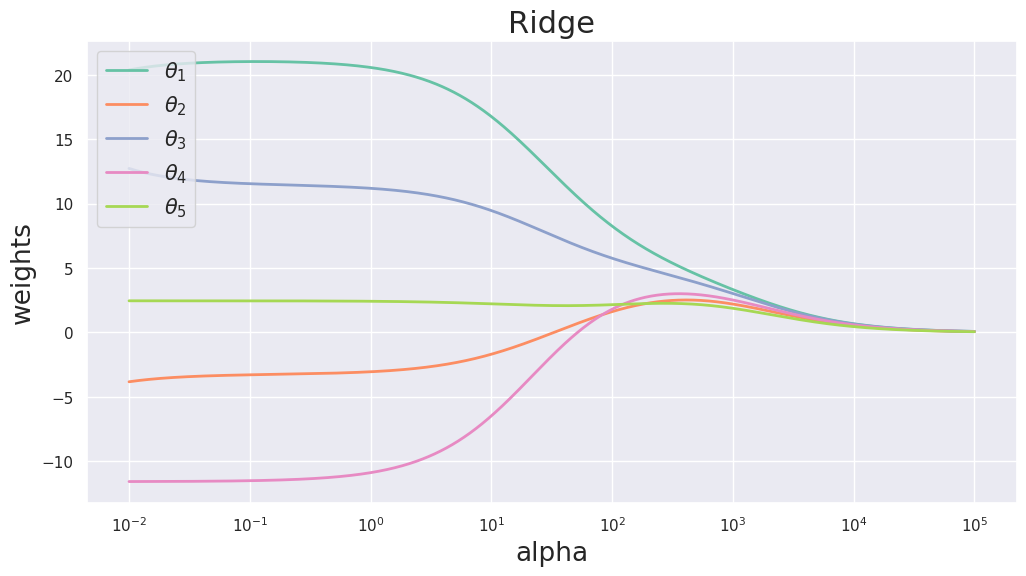

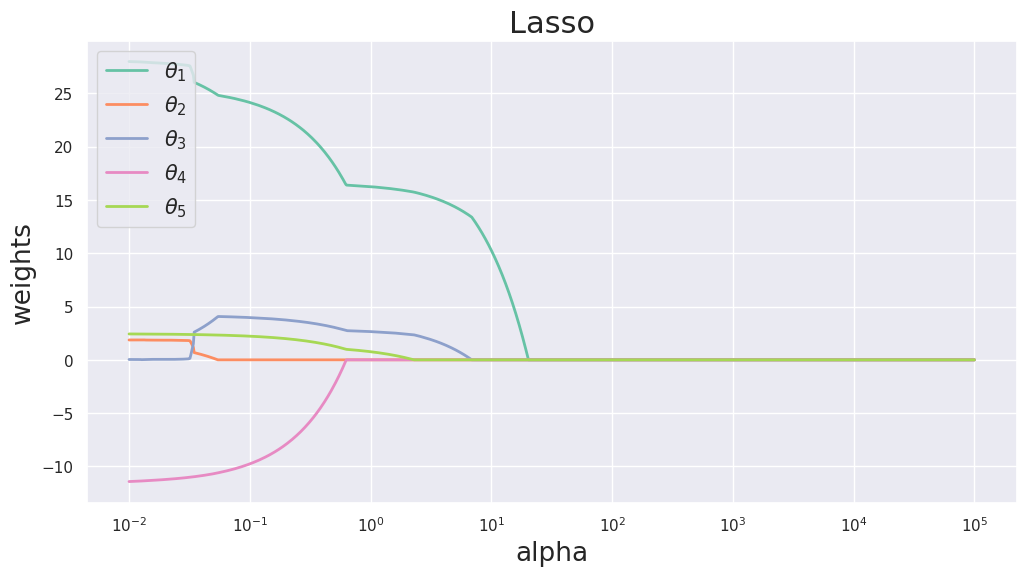

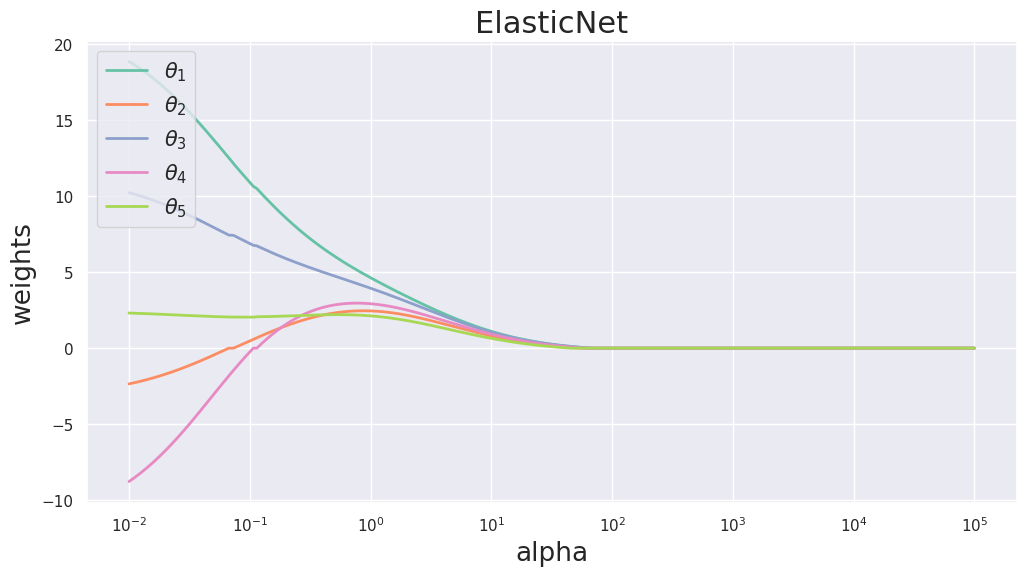

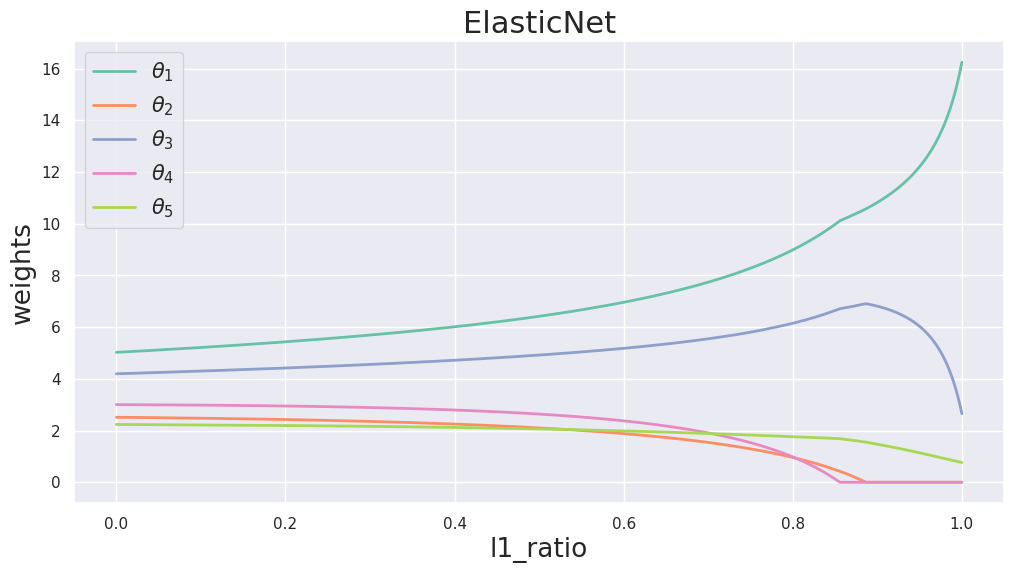

In [ ]:
draw_track(Ridge(fit_intercept=True), X_train_scaled, y_train, -2, 5, 1000,
           title='Ridge')
draw_track(Lasso(fit_intercept=True), X_train_scaled, y_train, -2, 5, 1000,
           title='Lasso')
draw_track(ElasticNet(fit_intercept=True, l1_ratio=0.2), X_train_scaled, y_train, -2, 5, 1000,
           title='ElasticNet')
draw_l1_ratio(ElasticNet(fit_intercept=True, max_iter=1000), X_train_scaled, y_train, 0, 1, 1000, title='ElasticNet')

Для всех регрессий оптимальное значение $\alpha$ лежит в промежутке $[10^{-1}, 10]$, при больших значениях зануляются веса, а при меньших - регуляризация слишком слабая.

Расчитайте индекс обусловленности для МНК-решения. Можно ли сделать вывод о мультиколлинеарности данных?  
Нарисуйте график зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии.

In [ ]:
cond_mnk = cond(X_train)

print(f"Индекс обусловленности для МНК-решения: {cond_mnk}")

Индекс обусловленности для МНК-решения: 51094.47308914123


Значение индекса обусловленности очень большое, что говорит о сильной мультиколлинеарности данных.

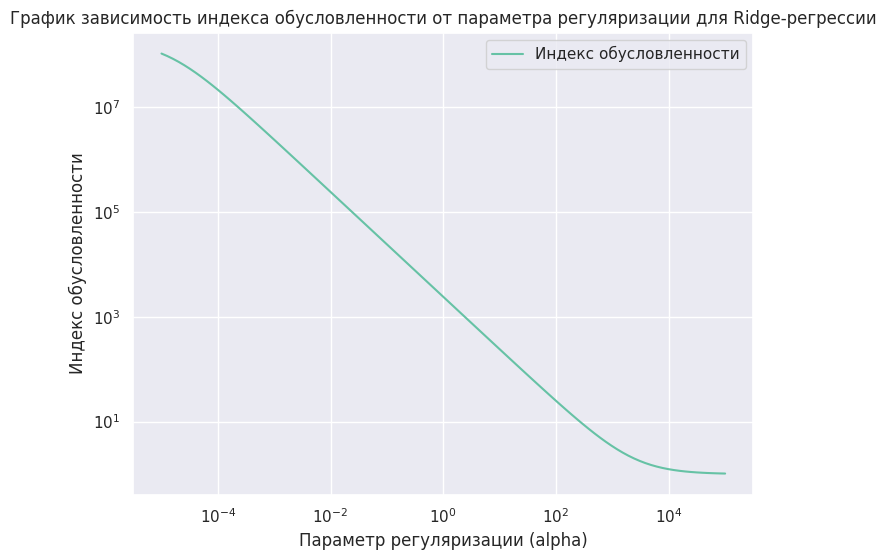

In [ ]:

# Диапазон значений регуляризации для Ridge
alphas = np.logspace(-5, 5, 100)

# Вычисление индекса обусловленности для каждого значения альфы
cond_numbers = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    # Вычисление индекса обусловленности по матрице признаков после регуляризации
    cond_number = cond(X_scaled.T @ X_scaled + alpha * np.eye(X_scaled.shape[1]))
    cond_numbers.append(cond_number)

# Построение графика зависимости индекса обусловленности от параметра регуляризации
plt.figure(figsize=(8, 6))
plt.plot(alphas, cond_numbers, label="Индекс обусловленности")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Параметр регуляризации (alpha)')
plt.ylabel('Индекс обусловленности')
plt.title('График зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии')
plt.grid(True)
plt.legend()
plt.show()


**3.** На обучающей выборке с помощью поиска по сетке определите наилучшие параметры для Ridge, Lasso, Elastic моделей. В качестве метрики качества используйте среднеквадратичную ошибку (MSE).

*Замечание.* Не забудьте, что при стандартизации была использована вся обучающая выборка, а внутри кросс-валидации на каждой итерации рассматривается своя валидационная выборка, которая не должна стандартизироваться по данным, посчитанным частично на ней самой. Вам может помочь [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Используйте его в качестве аргумента model



<b><font color="#00b565" size="5">Исправил код</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> <i>При печати оптимальных значений метрики нет округления. </i>

In [ ]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

# Параметры для поиска по сетке
param_grid_ridge = {
    'model__alpha': np.logspace(-4, 4, 10)
}

param_grid_lasso = {
    'model__alpha': np.logspace(-4, 4, 10)
}

param_grid_elastic = {
    'model__alpha': np.logspace(-4, 4, 10),
    'model__l1_ratio': np.linspace(0, 1, 10)
}

# Настройка поиска по сетке для каждой модели
ridge_search = GridSearchCV(ridge_pipeline, param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
lasso_search = GridSearchCV(lasso_pipeline, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
elastic_search = GridSearchCV(elastic_pipeline, param_grid_elastic, scoring='neg_mean_squared_error', cv=5)

ridge_search.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)
elastic_search.fit(X_train, y_train)

# Вывод параметров с точностью до 5 знаков после запятой
def print_best_params(search, model_name):
    print(f"Лучшие параметры для {model_name}:")
    for key, value in search.best_params_.items():
        print(f"  {key}: {value:.5f}")
    print(f"Лучшее значение MSE для {model_name}: {-search.best_score_:.5f}")

print_best_params(ridge_search, "Ridge")
print_best_params(lasso_search, "Lasso")
print_best_params(elastic_search, "ElasticNet")


Лучшие параметры для Ridge:
  model__alpha: 0.35938
Лучшее значение MSE для Ridge: 34.92605
Лучшие параметры для Lasso:
  model__alpha: 0.00599
Лучшее значение MSE для Lasso: 34.94539
Лучшие параметры для ElasticNet:
  model__alpha: 0.00599
  model__l1_ratio: 0.77778
Лучшее значение MSE для ElasticNet: 34.92258


На тестовой части данных сравните качество моделей с оптимальными параметрами. Какая модель дала лучший результат?

In [ ]:
# Оценка моделей на тестовой выборке
ridge_best_model = ridge_search.best_estimator_
lasso_best_model = lasso_search.best_estimator_
elastic_best_model = elastic_search.best_estimator_

y_pred_ridge = ridge_best_model.predict(X_test)
y_pred_lasso = lasso_best_model.predict(X_test)
y_pred_elastic = elastic_best_model.predict(X_test)

print(f"MSE на тестовой выборке (Ridge): {mean_squared_error(y_test, y_pred_ridge):.5f}")
print(f"MSE на тестовой выборке (Lasso): {mean_squared_error(y_test, y_pred_lasso):.5f}")
print(f"MSE на тестовой выборке (ElasticNet): {mean_squared_error(y_test, y_pred_elastic):.5f}")

MSE на тестовой выборке (Ridge): 33.57751
MSE на тестовой выборке (Lasso): 33.48659
MSE на тестовой выборке (ElasticNet): 33.65107


<b><font color="#00b565" size="5">===== Конец исправлений =====</font></b>

Все используемые модели регрессии дали хороший результат, что позволяет успешно применять их для данных из нашей задачи.

**4.** Сделайте общий вывод по задаче.

**Вывод:** В данной задаче были изучены Ridge, Lasso и Elastic регрессии, все они оказались эффективными для наших данных при оптимальном подборе гиперпараметров, а также помогли избежать проблемы мультиколлинеарности.